# Imports

In [50]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./..')
sys.path.append('./../..')

from utils import robust_percentile_normalization, shift_stimulus_to_phosphene_centroid

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from dynaphos import utils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator


import math

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulator

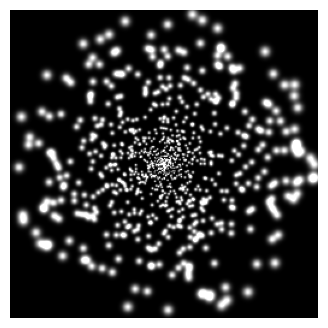

In [52]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')
params['run']['view_angle'] = 16

# open from pickle file:
path = '../electrode_schemes/defaultcoordinatemap_1024.pickle' # view_angle = 16
# path = '../electrode_schemes/4utaharrays.pickle' # view_angle = 16
# path = '../electrode_schemes/1utaharray.pickle' # view_angle = 0.4
# path = '../electrode_schemes/neuralink.pickle' # view_angle = 25
# path = '../electrode_schemes/utahRFs.pickle' # view_angle = 6

with open(path, 'rb') as f:
    phosphene_coords = pickle.load(f)

n_phosphenes = len(phosphene_coords)


# # Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu()[0], cmap='gray')
plt.axis('off')
plt.show()

In [53]:
# # Load the simulator configuration file (and adjust to preferences).
# params = utils.load_params('../config/params.yaml')
# params['run']['view_angle'] = 

# # filepath = r"/home/mappel/Dynaphos/spatial_frequency/electrode_schemes/StateOfElectrodeContactPoints_neuralink.txt"
# filepath = r"/home/mappel/Dynaphos/spatial_frequency/electrode_schemes/StateOfElectrodeContactPoints_utahRFs.txt"

# phos_map = utils.load_nestor_phosphene_map(filepath, drop_invalid=False, as_polar=True)


# simulator = PhospheneSimulator(params, phos_map)

# # save as pickle
# with open('../electrode_schemes/utahRFs.pickle', 'wb') as f:
#     pickle.dump(phos_map, f)

In [54]:
# import os
# import json
# import pickle
# import numpy as np

# from dynaphos.cortex_models import get_mapping_from_visual_field_to_cortex
# # (make sure your PYTHONPATH includes the dynaphos/ folder)

# # 2) load the “visual‐field” map you already generated
# path = '../electrode_schemes/1utaharray.pickle'
# with open(path,'rb') as f:
#     phosphene_map = pickle.load(f)

# # pull out the visual coords (x_vis, y_vis in degrees)
# try:
#     x_vis, y_vis = phosphene_map.cartesian            # a Map instance
# except AttributeError:
#     x_vis = np.array(phosphene_map['x'])
#     y_vis = np.array(phosphene_map['y'])
# else:
#     x_vis = np.array(x_vis)
#     y_vis = np.array(y_vis)

# # 3) build the inverse‐mapping: visual → cortical
# vis2cort = get_mapping_from_visual_field_to_cortex(params['cortex_model'])

# # vectorize and apply
# z_vis = x_vis + 1j * y_vis          # complex planar visual coords
# w_cor = vis2cort(z_vis)             # same shape, in cortical “w”‐space

# # split back out
# x_cor = w_cor.real.tolist()
# y_cor = w_cor.imag.tolist()

# # 4) dump JSON that Unity will treat as “cortical” coords
# out = {'x': [float(x) for x in x_cor],
#        'y': [float(y) for y in y_cor]}

# # use pickle name
# name = path.split('/')[-1].split('.')[0]  # e.g. 'neuralink'
# out_path = f'../electrode_schemes/json/{name}.json'
# os.makedirs(os.path.dirname(out_path), exist_ok=True)
# with open(out_path, 'w') as f:
#     json.dump(out, f, indent=2)

# print(f"Saved {len(x_cor)} CORTICAL electrodes → {out_path}")

# Uniformity

Loss = 0.0018: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.15iter/s]


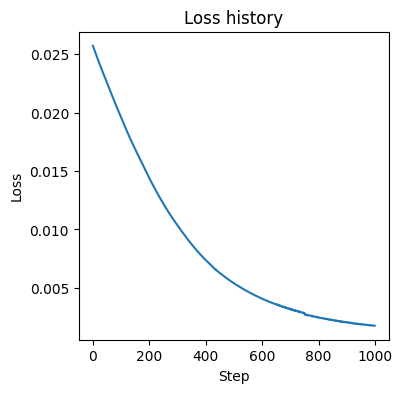

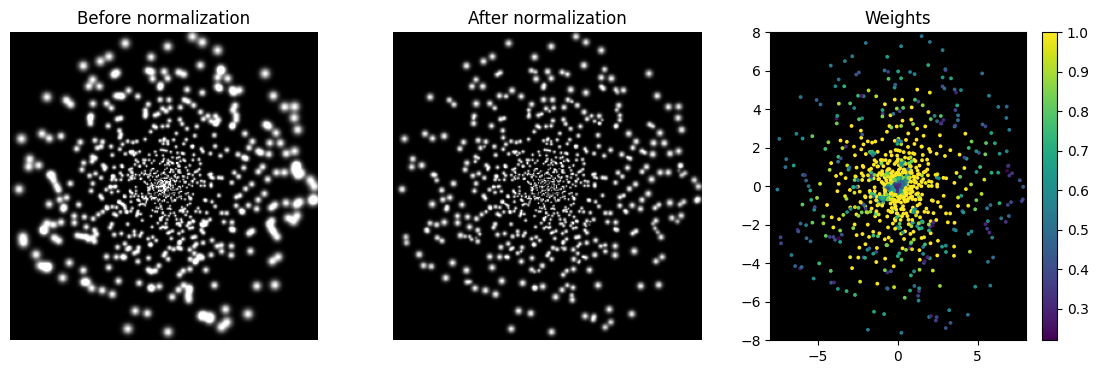

Percentage of amplitude: 73.37%


In [55]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.1,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.005,
    steps=1000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

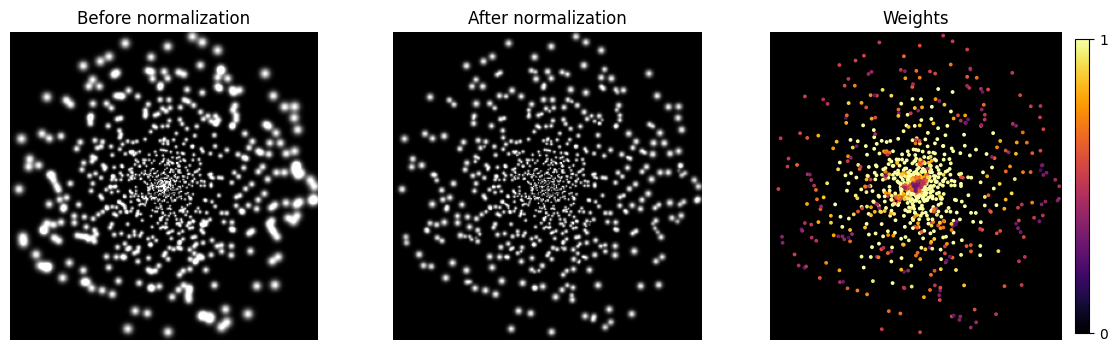

In [56]:
# For the paper

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('After normalization')
# third subplot: weights
ax = plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
cmap = 'inferno'
sc = ax.scatter(
    phosphene_coords._x, -phosphene_coords._y,
    c=stim_weights.cpu(), cmap=cmap, s=3, vmin=0.0, vmax=1.0
)

# full-FOV limits
fov = simulator.params['run']['view_angle']
ax.set_xlim(-fov/2, fov/2)
ax.set_ylim(-fov/2, fov/2)

# black background
ax.set_facecolor('black')

# remove ticks and spines but keep facecolor
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

# colorbar with only 0 and 1 
cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cb.set_ticks([0.0, 1.0])
cb.set_ticklabels(['0', '1'])

plt.title('Weights')
plt.show()

# Phosphene Density Maps

In [57]:
from phosphene.density import VisualFieldMapper

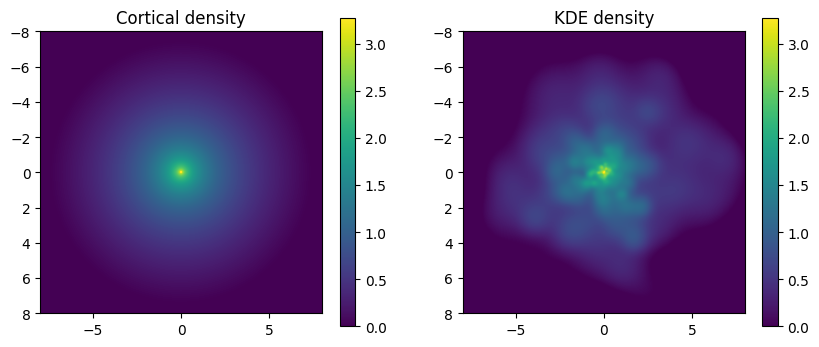

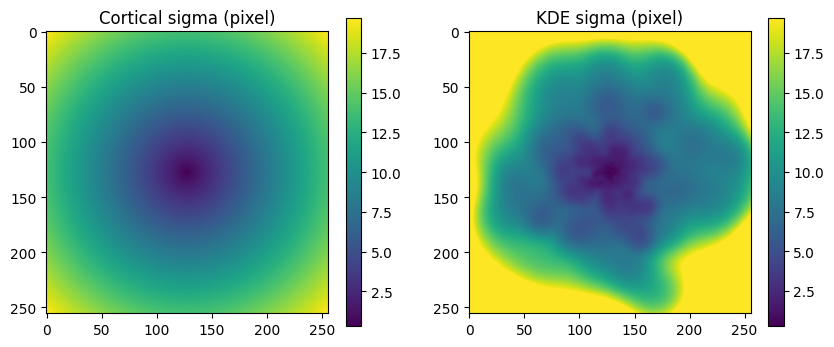

In [58]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=n_phosphenes)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=6, alpha=1.0, total_phosphenes=n_phosphenes)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

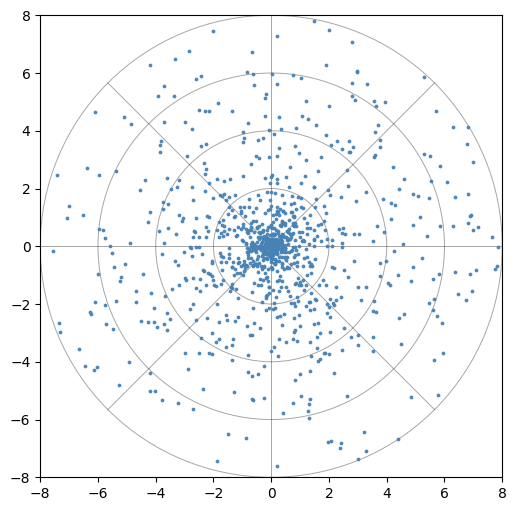

In [59]:
# plot only the phosphene locations in the visual fiel, no axis labels
plt.figure(figsize=(6, 6))
plt.scatter(phosphene_coords._x, -phosphene_coords._y, s=3, alpha=0.9, color='steelblue', zorder=3)
# plt.axis('off')

half_angle = params['run']['view_angle'] / 2
max_rad = half_angle

circle_radii = np.linspace(2, max_rad, 4)
phis_full   = np.linspace(0, 2*np.pi, 8, endpoint=False)
deg_labels  = np.arange(0, 360, 45)


# add circle radii
for R in circle_radii:
    circ = plt.Circle((0, 0), R, color='black', fill=False, lw=0.7, alpha=0.35, zorder=1)
    plt.gca().add_artist(circ)

# add radial lines
for φ, deg in zip(phis_full, deg_labels):
    plt.plot([0, max_rad * np.cos(φ)], [0, max_rad * np.sin(φ)],
             color='black', lw=0.7, alpha=0.35, zorder=1)



pad = 0.0
plt.xlim(-max_rad - pad, max_rad + pad)
plt.ylim(-max_rad - pad, max_rad + pad)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



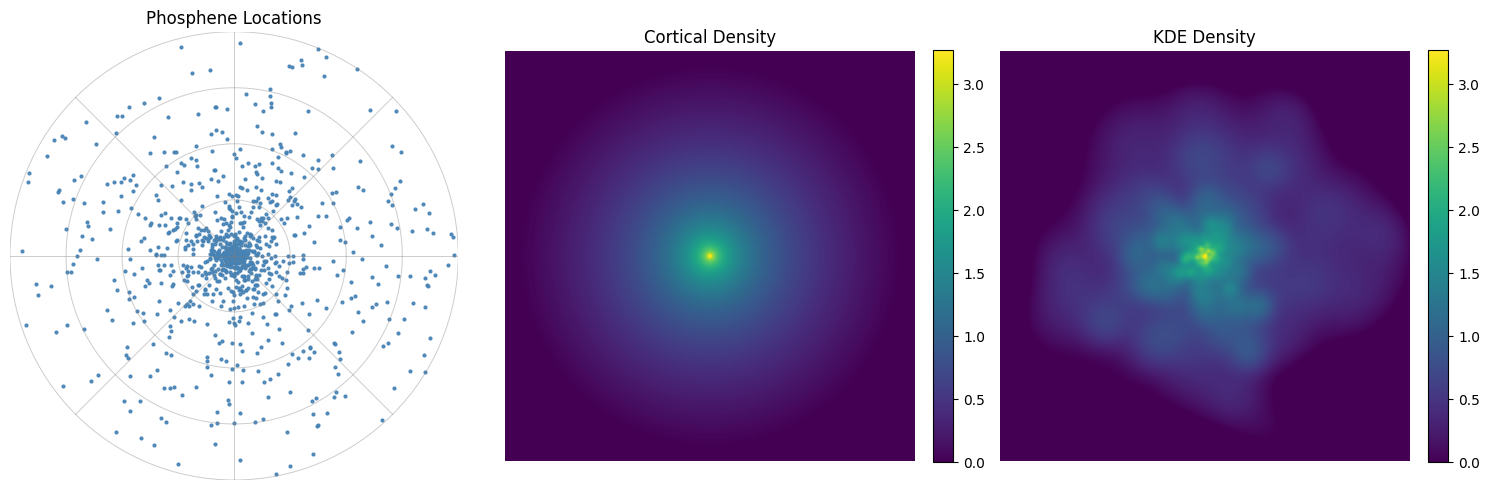

In [60]:
fov    = params['run']['view_angle']
half   = fov / 2
max_rad = half

# set up figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15,5),
                         subplot_kw={'aspect':'equal'})

# 1. phosphene scatter
ax = axes[0]
ax.scatter(phosphene_coords._x,
           phosphene_coords._y,
           s=4, alpha=0.9, color='steelblue')
# draw concentric circles and radial lines
radii = np.linspace(max_rad/4, max_rad, 4)
phis  = np.linspace(0, 2*np.pi, 8, endpoint=False)
for R in radii:
    c = plt.Circle((0,0), R, fill=False, color='gray',
                   lw=0.7, alpha=0.4, zorder=1)
    ax.add_artist(c)
for phi in phis:
    ax.plot([0, max_rad*np.cos(phi)],
            [0, max_rad*np.sin(phi)],
            color='gray', lw=0.7, alpha=0.4, zorder=1)
ax.set_xlim(-max_rad, max_rad)
ax.set_ylim(-max_rad, max_rad)
ax.set_title('Phosphene Locations')
ax.axis('off')

# 2. cortical density
ax = axes[1]
im1 = ax.imshow(np.log10(density_cortical),
                cmap='viridis',
                extent=[-half, half, half, -half],
                vmin=0)
fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('Cortical Density')
ax.axis('off')

# 3. KDE density
ax = axes[2]
im2 = ax.imshow(np.log10(density_kde),
                cmap='viridis',
                extent=[-half, half, half, -half],
                vmin=0,
                vmax=np.log10(density_cortical.max()))
fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('KDE Density')
ax.axis('off')

plt.tight_layout()
plt.show()

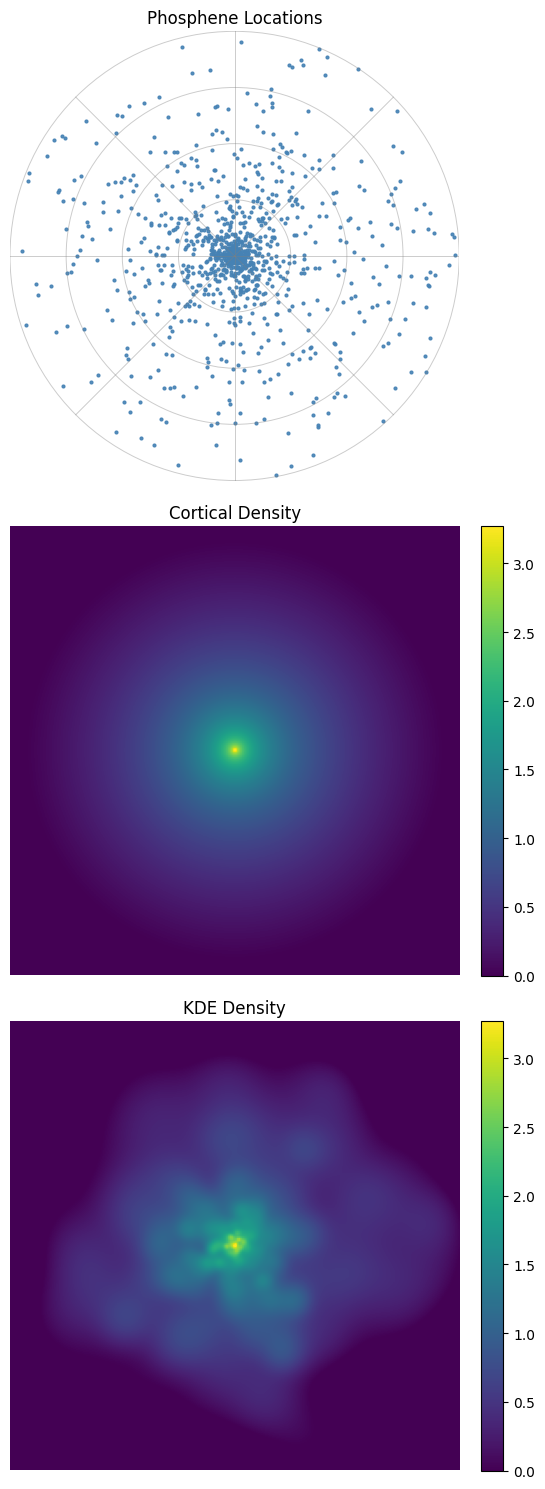

In [61]:
fov     = params['run']['view_angle']
half    = fov / 2
max_rad = half

# create a tall figure with three rows
fig, axes = plt.subplots(3, 1,
                         figsize=(6, 15),
                         subplot_kw={'aspect':'equal'})

# 1. Phosphene locations
ax = axes[0]
ax.scatter(phosphene_coords._x,
           phosphene_coords._y,
           s=4, alpha=0.9, color='steelblue')
for R in np.linspace(max_rad/4, max_rad, 4):
    c = plt.Circle((0,0), R, fill=False,
                   color='gray', lw=0.7, alpha=0.4, zorder=1)
    ax.add_artist(c)
for phi in np.linspace(0, 2*np.pi, 8, endpoint=False):
    ax.plot([0, max_rad*np.cos(phi)],
            [0, max_rad*np.sin(phi)],
            color='gray', lw=0.7, alpha=0.4, zorder=1)
ax.set_xlim(-max_rad, max_rad)
ax.set_ylim(-max_rad, max_rad)
ax.set_title('Phosphene Locations')
ax.axis('off')

# 2. Cortical density
ax = axes[1]
im1 = ax.imshow(np.log10(density_cortical),
                cmap='viridis',
                extent=[-half, half, half, -half],
                vmin=0)
fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('Cortical Density')
ax.axis('off')

# 3. KDE density
ax = axes[2]
im2 = ax.imshow(np.log10(density_kde),
                cmap='viridis',
                extent=[-half, half, half, -half],
                vmin=0,
                vmax=np.log10(density_cortical.max()))
fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('KDE Density')
ax.axis('off')

plt.tight_layout()
plt.show()


/scratch-local/mappel.13119605/ipykernel_1258893/1592488411.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


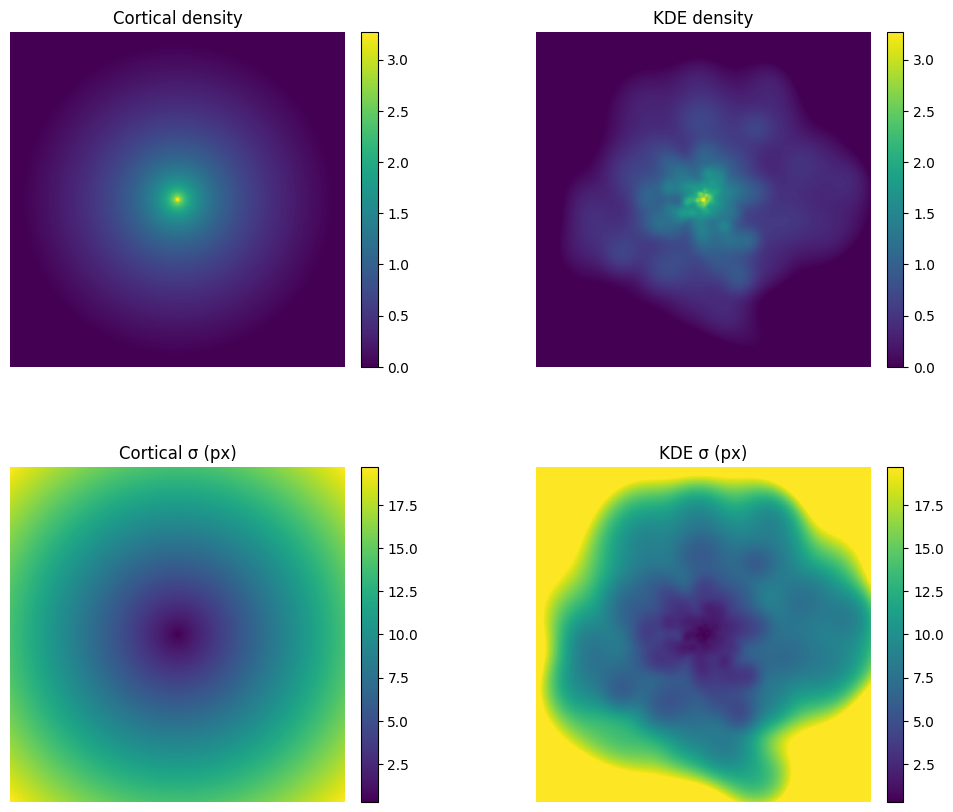

In [62]:

fov     = params['run']['view_angle']
half    = fov / 2
log_max = np.log10(density_cortical.max())

fig, axes = plt.subplots(2, 2, figsize=(12, 10),
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

# Top‐left: cortical density
ax = axes[0, 0]
im = ax.imshow(np.log10(density_cortical),
               cmap='viridis',
               extent=[-half, half, half, -half],
               vmin=0, vmax=log_max)
ax.set_title('Cortical density')
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Top‐right: KDE density
ax = axes[0, 1]
im = ax.imshow(np.log10(density_kde),
               cmap='viridis',
               extent=[-half, half, half, -half],
               vmin=0, vmax=log_max)
ax.set_title('KDE density')
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Bottom‐left: cortical sigma
ax = axes[1, 0]
im = ax.imshow(sigma_cortical_pix,
               cmap='viridis',
               vmin=sigma_cortical_pix.min(),
               vmax=sigma_cortical_pix.max())
ax.set_title('Cortical σ (px)')
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Bottom‐right: KDE sigma
ax = axes[1, 1]
im = ax.imshow(sigma_kde_pix,
               cmap='viridis',
               vmin=sigma_cortical_pix.min(),
               vmax=sigma_cortical_pix.max())
ax.set_title('KDE σ (px)')
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

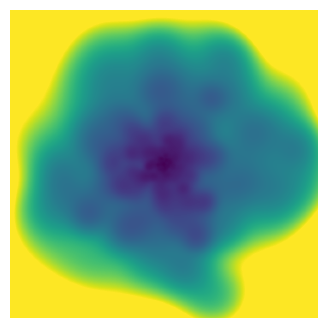

In [63]:
# plot only the KDE sigma map with color bar, without axis, for the paper

plt.figure(figsize=(4, 4))
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.axis('off')
# plt.colorbar()
# plt.title('KDE sigma (pixel)')
plt.show()

In [64]:
# Find centroid
x_center, y_center = mapper.centroid_of_density(density_kde)
print(f'Centroid of cortical density: ({x_center:.2f}, {y_center:.2f}) degrees')

Centroid of cortical density: (0.04, -0.02) degrees


# Image processing for Phosphene Vision

In [65]:
from spatial_frequency.components.SeparableModulated2d import SeparableModulatedConv2d
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets import CocoDetection

# 1) Define your weighted‐grayscale Lambda
rgb_weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(3,1,1)
to_weighted_grayscale = transforms.Lambda(
    lambda img: (img * rgb_weights).sum(dim=0, keepdim=True)
)

# 2) Build your full pipeline
t = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),            # → [C,H,W] in [0,1]
    to_weighted_grayscale,            # → [1,H,W] weighted luma
])

folder = '/projects/prjs0344/Dynaphos/data/example_faces_LaPa/'
# folder = '/projects/prjs0344/Dynaphos/data/SUN/SUN397'

data_loader = DataLoader(
    ImageFolder(folder, transform=t),
    batch_size=1,
    shuffle=False
)

# where you unzipped train2017/val2017 and annotations/
# data_root = "/projects/prjs0344/Dynaphos/data/coco"
# img_dir    = os.path.join(data_root, "val2017")
# ann_file   = os.path.join(data_root, "annotations", "instances_val2017.json")

# coco_val = CocoDetection(root=img_dir,
#                          annFile=ann_file,
#                          transform=t)
# data_loader = DataLoader(coco_val, batch_size=1, shuffle=False)

In [66]:
sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach()

mod_layer = SeparableModulatedConv2d(
    in_channels=1,
    sigma_map=sigma_map_tensor
).cuda()
mod_layer.eval()

SeparableModulatedConv2d()

In [67]:
def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [68]:
import torch
import numpy as np
import cv2

def make_stim_phos(simulator, stim: torch.Tensor, amplitude, threshold, stim_weights):
    """
    stim: [B, C, H, W]
    returns: (stim, phos) both [B, C, H, W]
    """
    simulator.reset()
    elec = simulator.sample_stimulus(stim, rescale=True)
    elec = robust_percentile_normalization(
        elec,
        amplitude,
        threshold=threshold,
        low_perc=5,
        high_perc=90,
        gamma=1/3
    )
    elec = elec * stim_weights
    phos = simulator(elec)

    # ensure [B,C,H,W]
    if phos.dim() == 2:          # [H,W]
        phos = phos.unsqueeze(0).unsqueeze(0)
    elif phos.dim() == 3:        # [C,H,W]
        phos = phos.unsqueeze(0)
    return stim, phos

image_processing_dict = {}
threshold = params['thresholding']['rheobase']

for idx, (images, _) in enumerate(data_loader):
    images = images.cuda()             # [1,1,H,W]
    images = torch.Tensor(shift_stimulus_to_phosphene_centroid(
        img=images[0][0].cpu().numpy(),  # [H,W]
        centroid=(x_center, y_center),  # center at (0,0) in degrees
        fov=params['run']['view_angle'],# field of view in degrees
        mode='constant',                # fill offscreen with zeros
        cval=0.0                        # constant value for padding
    )).unsqueeze(0).unsqueeze(0).cuda()  # [1,1,H,W]
    # print(images.shape)
    orig = images                    

    # DoG
    dog = mod_layer(orig)
    dog = dog.detach().cpu().clip(0, None)
    dog = (dog - dog.min())/(dog.max()-dog.min())
    dog = dog.cuda()

    # Canny
    npimg = (orig[0,0].cpu().numpy()*255).astype(np.uint8)
    ce = cv2.Canny(npimg,150,280).astype(np.float32)  # [H,W]
    # dilate 3x3
    ce = dilation3x3(torch.from_numpy(ce).unsqueeze(0)).squeeze(0).cpu().numpy()
    ce = torch.from_numpy(ce / (ce.max()+1e-8)).unsqueeze(0).unsqueeze(0).cuda()

    # Random Perlin (fixed)
    rp = rand_perlin_2d((256,256),(4,4))    # returns a torch.Tensor [H,W]
    rp = rp.float()                         # ensure float
    rp = (rp - rp.min())/(rp.max()-rp.min())
    rp = rp.unsqueeze(0).unsqueeze(0).cuda()  # [1,1,H,W]

    # stimulate & simulate
    stim_gs, phos_gs   = make_stim_phos(simulator, orig,  amplitude, threshold, stim_weights)
    stim_dog, phos_dog = make_stim_phos(simulator, dog,   amplitude, threshold, stim_weights)
    stim_ce, phos_ce   = make_stim_phos(simulator, ce,    amplitude, threshold, stim_weights)
    stim_rp, phos_rp   = make_stim_phos(simulator, rp,    amplitude, threshold, stim_weights)

    image_processing_dict[idx] = {
        'image': orig,            
        'grayscale': {
            'stim': stim_gs,       
            'phosphenes': phos_gs 
        },
        'DoG_response': {
            'stim': stim_dog,      
            'phosphenes': phos_dog
        },
        'canny_edge': {
            'stim': stim_ce,       
            'phosphenes': phos_ce
        },
        'random': {
            'stim': stim_rp,       
            'phosphenes': phos_rp
        }
    }

    if idx == 200:
        break


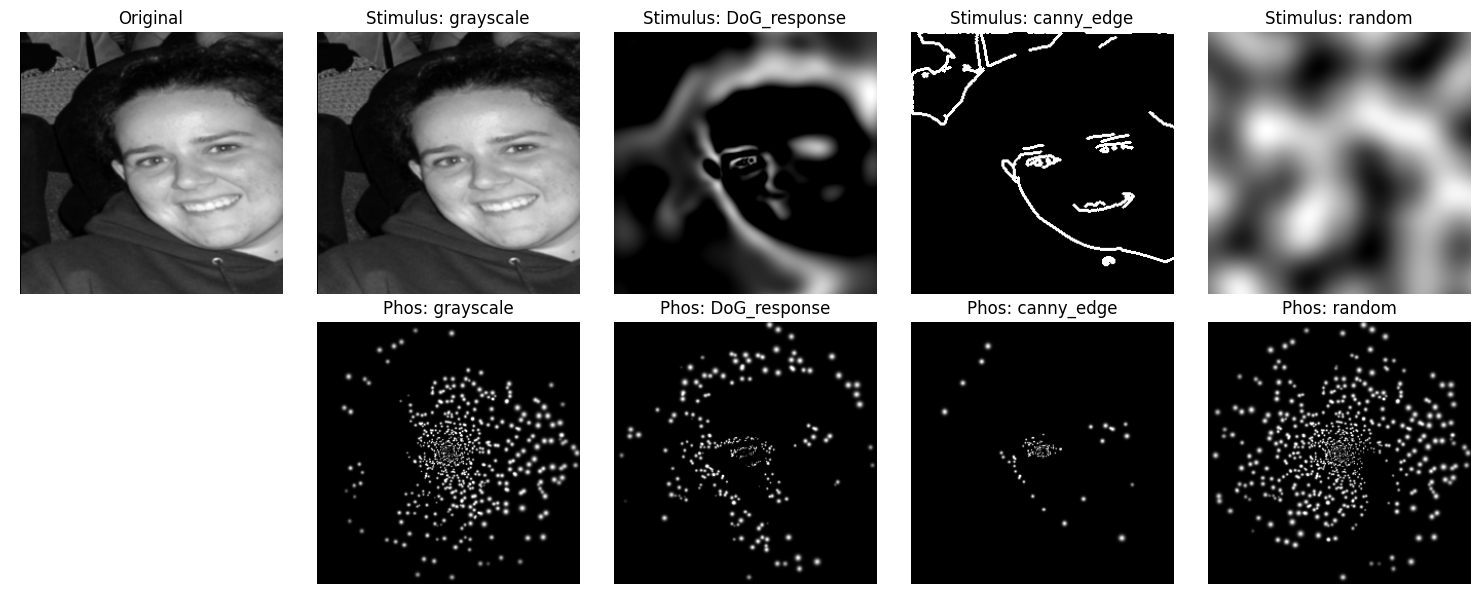

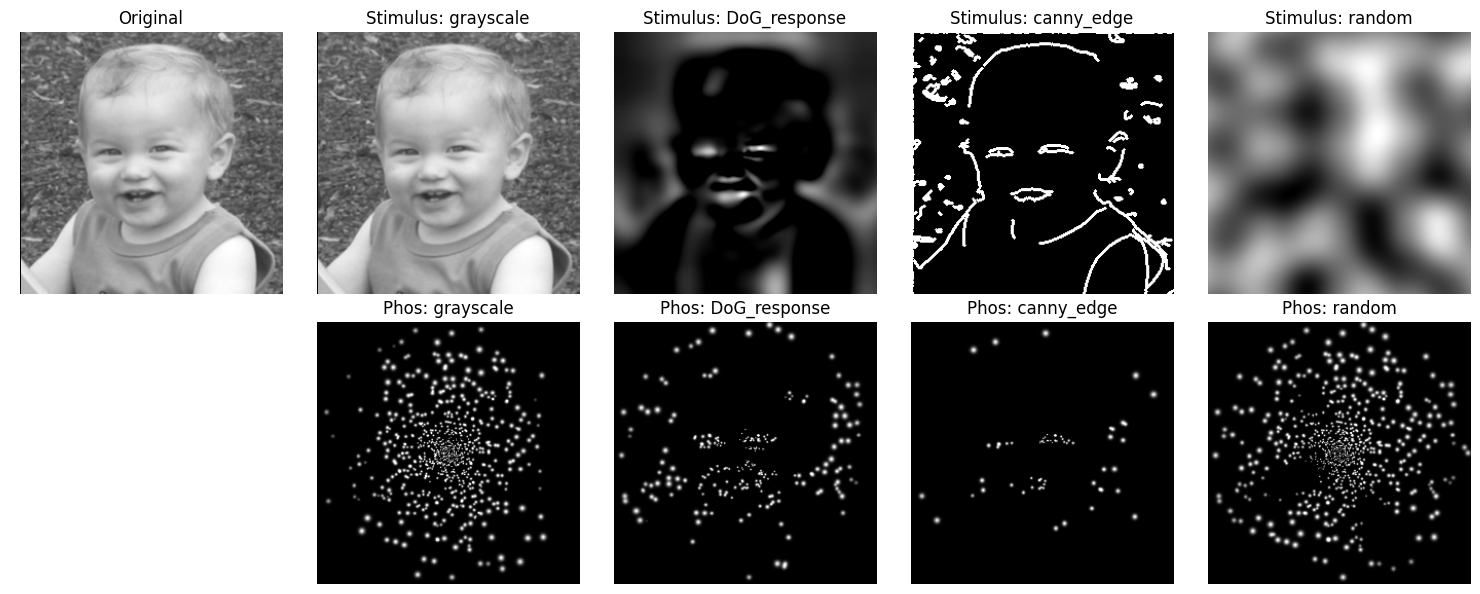

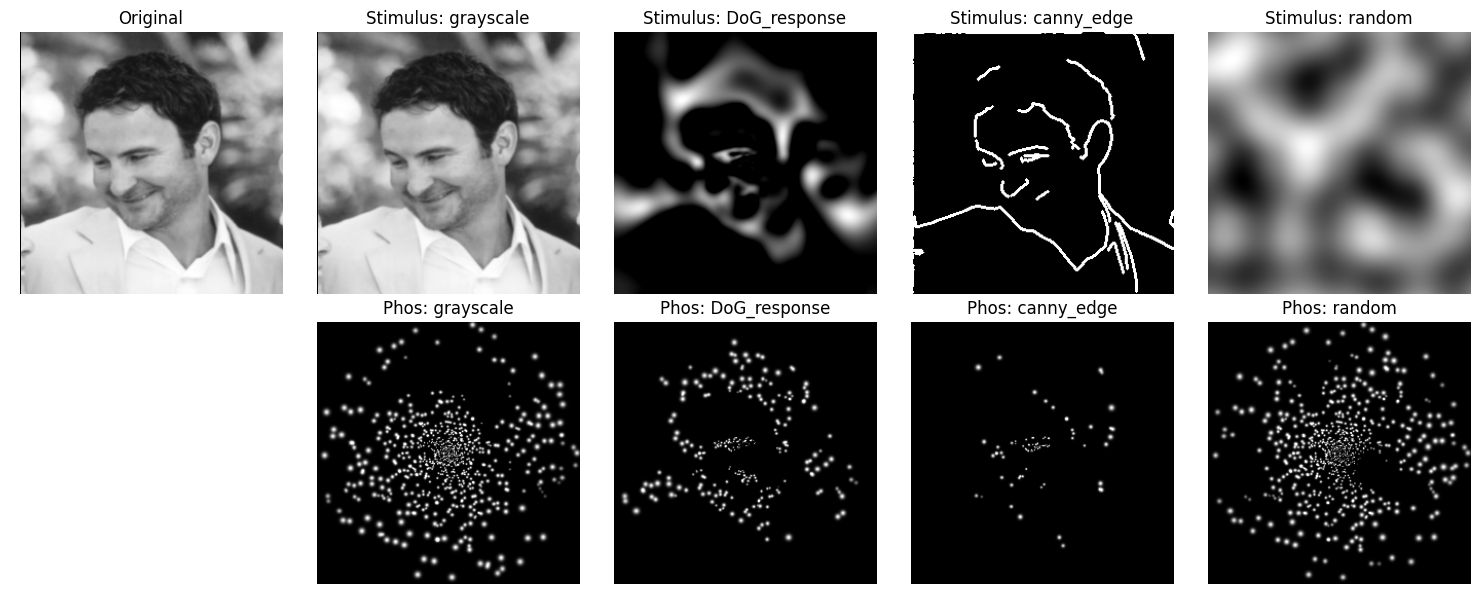

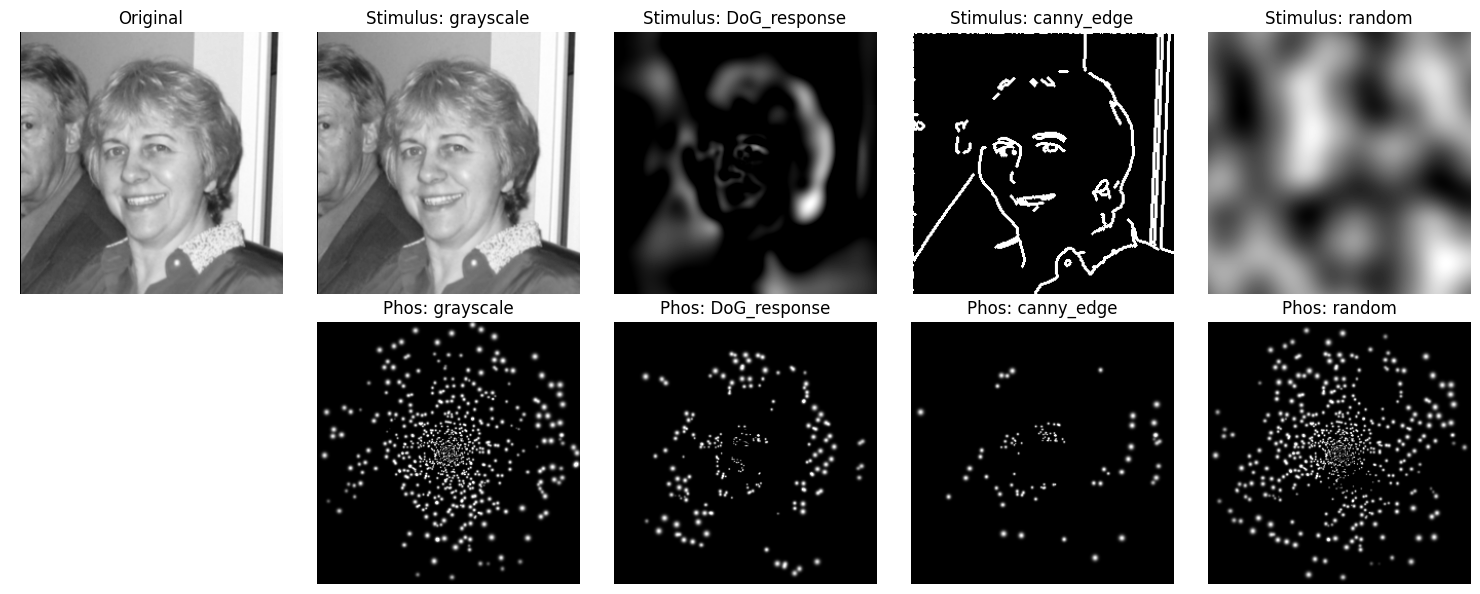

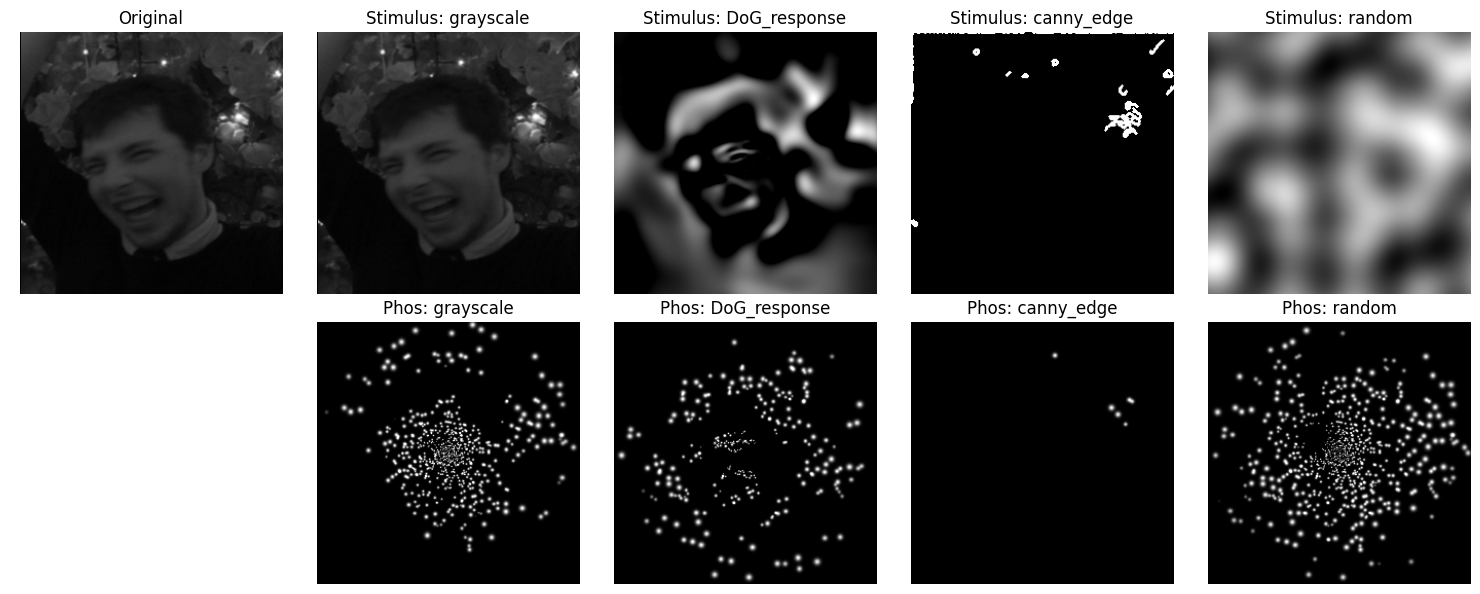

In [69]:
import matplotlib.pyplot as plt
torch.use_deterministic_algorithms(False)

def show_images(idx):
    data   = image_processing_dict[idx]
    # collect all the keys except the raw 'image'
    methods = [k for k in data.keys() if k != 'image']
    n_cols  = 1 + len(methods)   # one column for the original + one for each method

    fig, axes = plt.subplots(2, n_cols,
                             figsize=(3*n_cols, 6),
                             squeeze=False)

    # --- Row 0, Col 0: the original ---
    orig = data['image'][0, 0].cpu().numpy()
    ax = axes[0, 0]
    ax.imshow(orig, cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

    # leave the bottom-left empty (no phos for original)
    axes[1, 0].axis('off')

    for j, key in enumerate(methods, start=1):
        stim = data[key]['stim'][0, 0].cpu().numpy()
        phos = data[key]['phosphenes'][0, 0].cpu().numpy()

        # stimulus in row 0
        ax = axes[0, j]
        ax.imshow(stim, cmap='gray')
        ax.set_title(f'Stimulus: {key}')
        ax.axis('off')

        # phosphenes in row 1
        ax = axes[1, j]
        ax.imshow(phos, cmap='gray')
        ax.set_title(f'Phos: {key}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(0)  # Show the first example
show_images(1)  # Show the second example
show_images(2)  # Show the third example
show_images(3)  # Show the fourth example
show_images(4)  # Show the fifth example

In [70]:
# # For the paper
# index = 13
# # plot the original image, DoG response and phosphenes of the DoG separately
# orig = image_processing_dict[index]['image'][0, 0].cpu().numpy()
# dog = image_processing_dict[index]['DoG_response']['stim'][0, 0].cpu().numpy()
# phos_dog = image_processing_dict[index]['DoG_response']['phosphenes'][0, 0].cpu().numpy()

# plt.imshow(orig, cmap='gray')
# plt.tight_layout()
# plt.axis('off')
# plt.show()

# plt.imshow(dog, cmap='gray')
# plt.tight_layout()
# plt.axis('off')
# plt.show()

# plt.imshow(phos_dog, cmap='gray')
# plt.tight_layout()
# plt.axis('off')
# plt.show()

In [71]:
# # For the paper
# index = 4
# orig     = image_processing_dict[index]['image'][0, 0].cpu().numpy()
# dog      = image_processing_dict[index]['DoG_response']['stim'][0, 0].cpu().numpy()
# # phos_dog = image_processing_dict[index]['DoG_response']['phosphenes'][0, 0].cpu().numpy()

# # assume you have density_kde, and fov defined already
# half   = params['run']['view_angle'] / 2

# fig, axes = plt.subplots(3, 1, figsize=(6, 16), 
#                          gridspec_kw={'hspace': 0.3})

# # 1) KDE sigma
# im = axes[0].imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
# axes[0].set_title('KDE σ (px)')
# axes[0].axis('off')
# fig.colorbar(im, ax=axes[0])

# # 2) Original image
# axes[1].imshow(orig, cmap='gray')
# axes[1].set_title('Original Image')
# axes[1].axis('off')

# # 3) DoG response
# axes[2].imshow(dog, cmap='gray')
# axes[2].set_title('DoG Response')
# axes[2].axis('off')

# plt.tight_layout()
# plt.show()


/scratch-local/mappel.13119605/ipykernel_1258893/2820172888.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


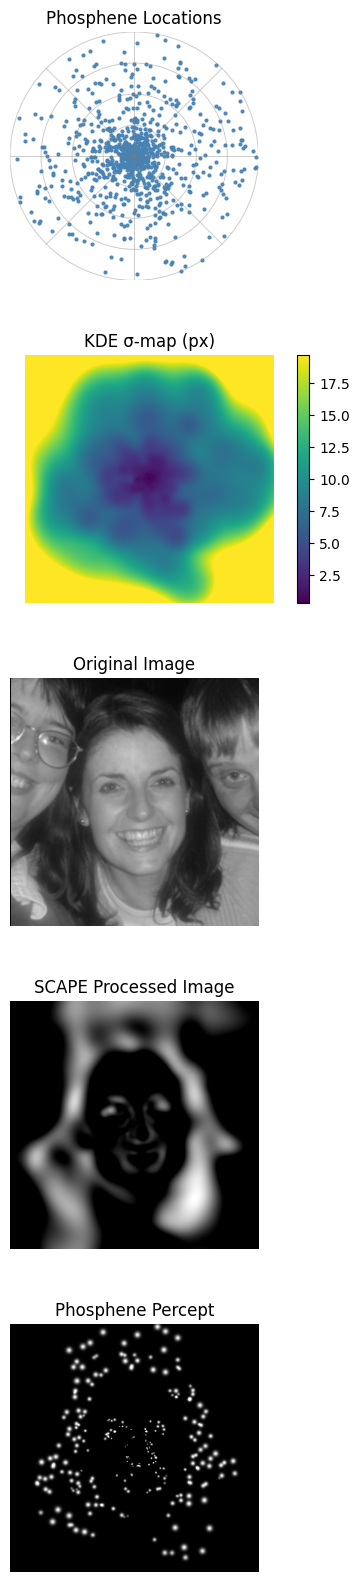

In [72]:
index = 13

orig = image_processing_dict[index]['image'][0, 0].cpu().numpy()
dog = image_processing_dict[index]['DoG_response']['stim'][0, 0].cpu().numpy()
phos_dog = image_processing_dict[index]['DoG_response']['phosphenes'][0, 0].cpu().numpy()

fov     = params['run']['view_angle']
half    = fov / 2

fig, axes = plt.subplots(5, 1,
                         figsize=(6, 20),
                         gridspec_kw={'hspace': 0.3},
                         subplot_kw={'aspect': 'equal'})

# 1) Phosphene locations
ax = axes[0]
ax.scatter(phosphene_coords._x,
           -phosphene_coords._y,
           s=4, alpha=0.9, color='steelblue')
ax.set_title('Phosphene Locations')
# add concentric circles and radial lines
radii = np.linspace(half/4, half, 4)
phis  = np.linspace(0, 2*np.pi, 8, endpoint=False)
for R in radii:
    c = plt.Circle((0,0), R, fill=False,
                   color='gray', lw=0.7, alpha=0.4, zorder=1)
    ax.add_artist(c)
for phi in phis:
    ax.plot([0, half*np.cos(phi)],
            [0, half*np.sin(phi)],
            color='gray', lw=0.7, alpha=0.4, zorder=1)
ax.set_xlim(-half, half)
ax.set_ylim(-half, half)
ax.axis('off')

# 2) KDE σ‐map
ax = axes[1]
im = ax.imshow(sigma_kde_pix,
               cmap='viridis', vmax=sigma_cortical_pix.max())
ax.set_title('KDE σ-map (px)')
ax.axis('off')
fig.colorbar(im, ax=ax)

# 3) Original image
ax = axes[2]
ax.imshow(orig, cmap='gray')
ax.set_title('Original Image')
ax.axis('off')

# 4) SCAPE Processed image
ax = axes[3]
ax.imshow(dog, cmap='gray')
ax.set_title('SCAPE Processed Image')
ax.axis('off')

# 5) Phosphene percept
ax = axes[4]
ax.imshow(phos_dog,
          cmap='gray',
          extent=[-half, half, half, -half])
ax.set_title('Phosphene Percept')
ax.axis('off')

plt.tight_layout()
plt.show()

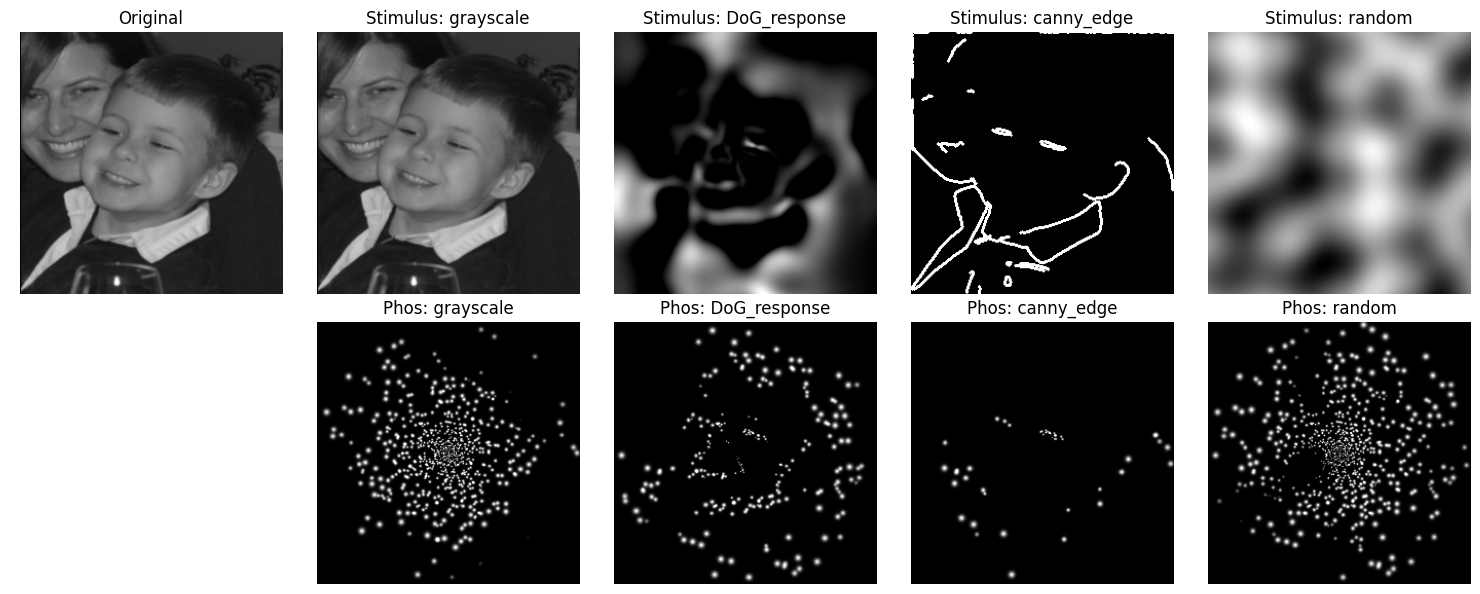

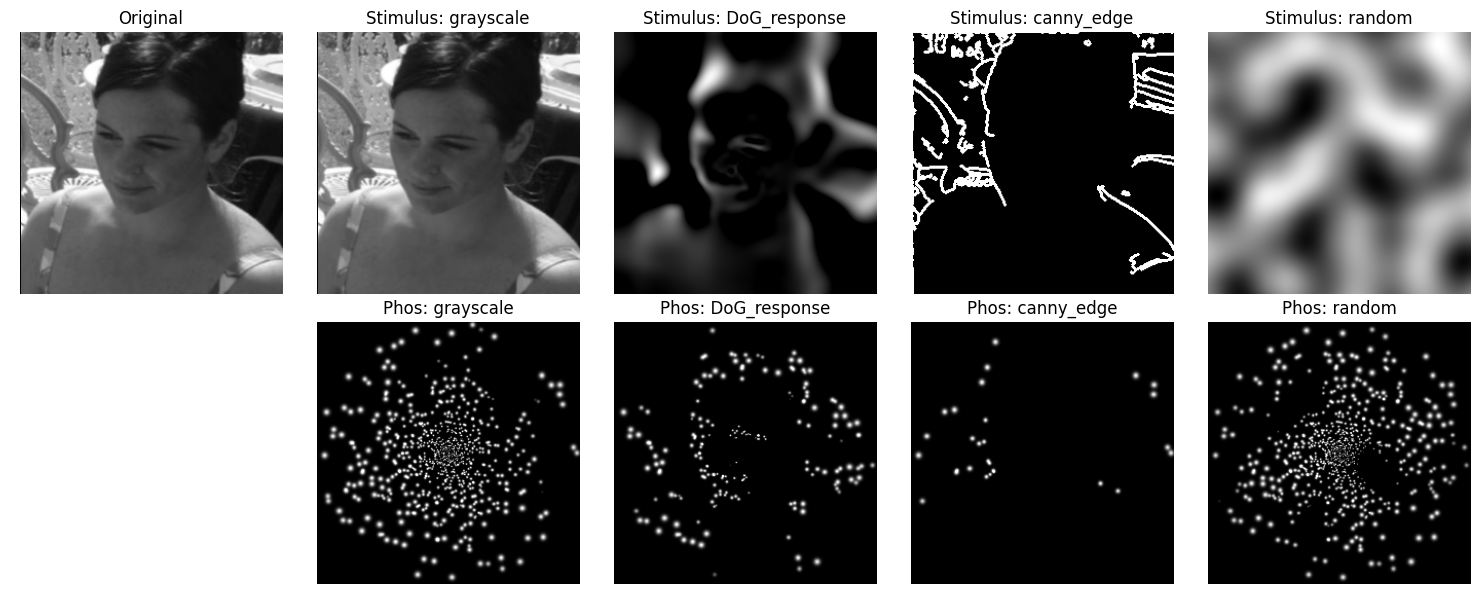

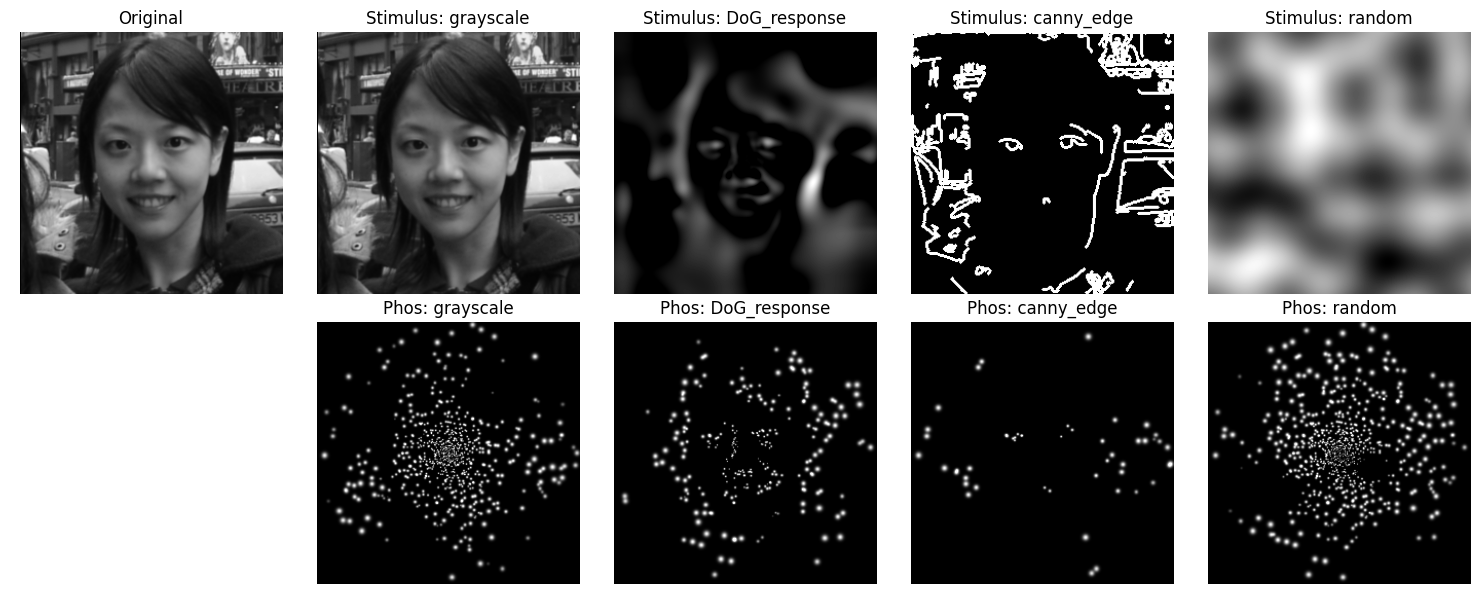

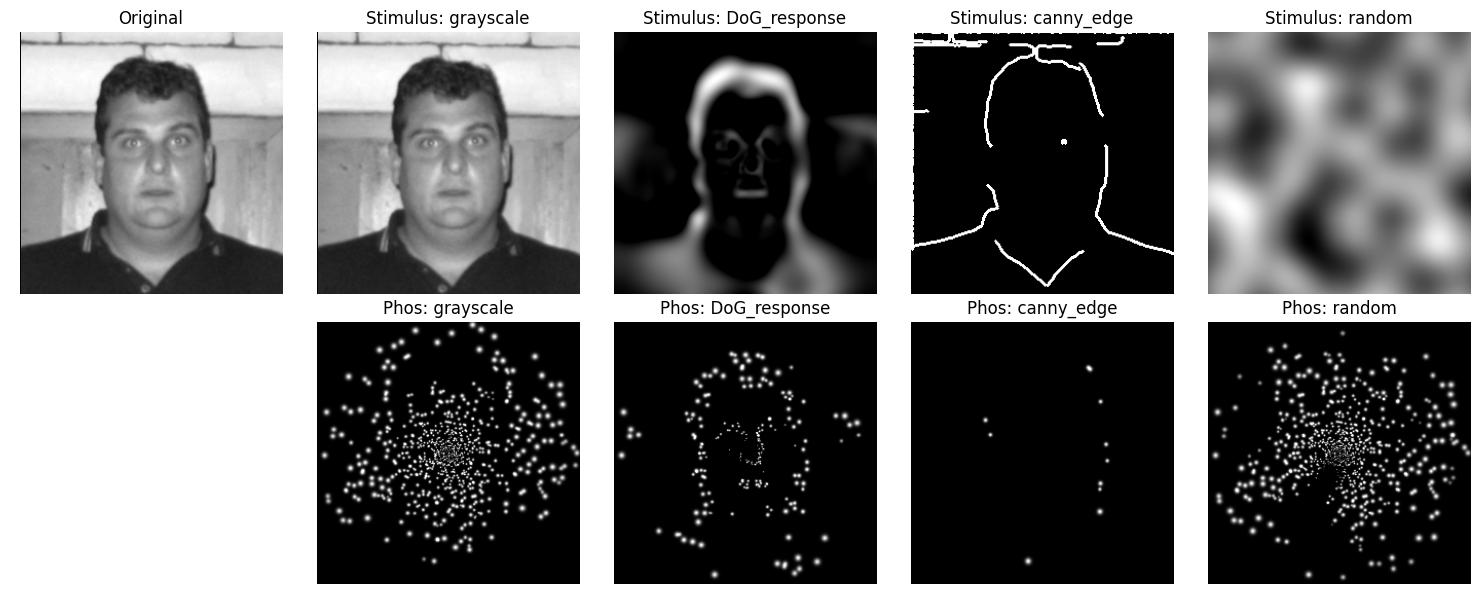

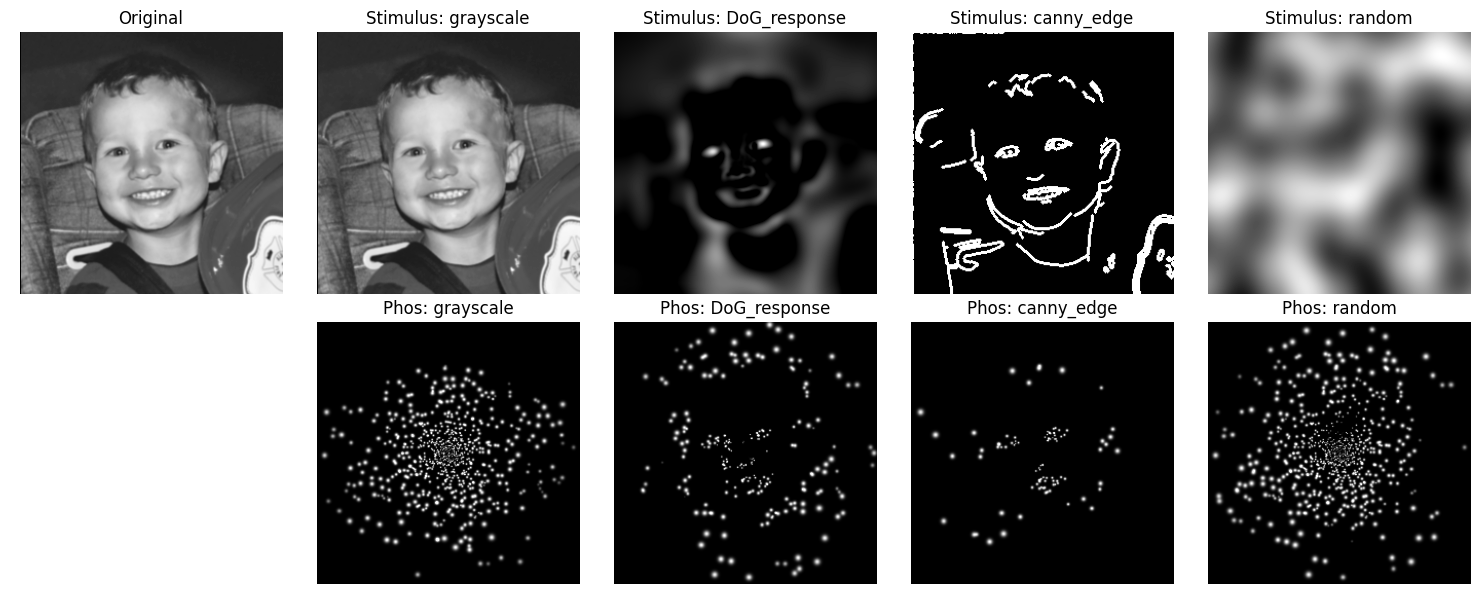

In [73]:
show_images(5)
show_images(6)  # Show the sixth example
show_images(7)  # Show the seventh example
show_images(8)  # Show the eighth example
show_images(9)  # Show the ninth example

In [74]:
# # print all the shapes of the image_processing_dict content
# for idx, data in image_processing_dict.items():
#     print(f"Image {idx}:")
#     print(f"  Original Image Shape: {data['image'].shape}")
#     for key, value in data.items():
#         if key != 'image':
#             print(f"  {key} Stimulus Shape: {value['stim'].shape}")
#             print(f"  {key} Phosphenes Shape: {value['phosphenes'].shape}")
#     print()  # Newline for better readability
    

# Evaluate

In [75]:
import seaborn as sns
sns.set_style("white", {"axes.grid": False})

def plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title=None, invert_cmap=True):
    """
    Plot three heatmaps showing the loss matrices for:
      1. Stimulus vs. Stimulus (symmetric)
      2. Stimulus vs. Phosphene (non-symmetric)
      3. Phosphene vs. Phosphene (symmetric)
    """
  	# everything to cpu
    stim_stim_matrix = stim_stim_matrix.cpu().numpy()
    stim_phos_matrix = stim_phos_matrix.cpu().numpy()
    phos_phos_matrix = phos_phos_matrix.cpu().numpy()

    sns.set(font_scale=0.7)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    plt.rcParams['text.usetex'] = False

    sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
                xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[0].set_title("Stimulus vs Stimulus")
    axes[0].xaxis.tick_top()

    sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[1].set_title("Stimulus vs Phosphene")
    axes[1].xaxis.tick_top()

    sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[2].set_title("Phosphene vs Phosphene")
    axes[2].xaxis.tick_top()

    if title:
        plt.suptitle(title, size=16)

    plt.tight_layout()
    plt.show()

In [76]:
def evaluate_loss_matrices(image_processing_dict, loss_fn):
    """
    Evaluate the loss matrices for a given loss function.
    """
    n_images = len(image_processing_dict) # number of images
    n_stimuli = len(image_processing_dict[0].keys())-1 # number of stimuli

    # Initialize the loss matrices
    stim_stim_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    stim_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    phos_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()

    for image in range(n_images):
        for i, (key, stim_dict) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
            if key == 'image':
                continue
            stim = stim_dict['stim'].cuda()
            phos = stim_dict['phosphenes'].cuda()

            for j, (key2, stim_dict2) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
                if key2 == 'image':
                    continue
                stim2 = stim_dict2['stim'].cuda()
                phos2 = stim_dict2['phosphenes'].cuda()

                # Compute the loss matrices
                stim_stim_matrix[i, j] += loss_fn(stim, stim2)
                stim_phos_matrix[i, j] += loss_fn(stim, phos2)
                phos_phos_matrix[i, j] += loss_fn(phos, phos2)

    # Normalize the loss matrices by the number of images
    stim_stim_matrix /= n_images
    stim_phos_matrix /= n_images
    phos_phos_matrix /= n_images

    return stim_stim_matrix, stim_phos_matrix, phos_phos_matrix

In [77]:
base_names = ["Gray", "Canny", "SCAPE DoG", "Random"]

# add (I_o) for the original/stimulus side
labels_stim = [rf"{name} $I_o$" for name in base_names]

# add (I_p) for the phosphene/output side
labels_phos = [rf"{name} $I_p$" for name in base_names]

print(labels_stim)

print(labels_phos)


['Gray $I_o$', 'Canny $I_o$', 'SCAPE DoG $I_o$', 'Random $I_o$']
['Gray $I_p$', 'Canny $I_p$', 'SCAPE DoG $I_p$', 'Random $I_p$']


In [78]:
matrix_dict = {}

### Feature Similarity Index Measure (FSIM) 

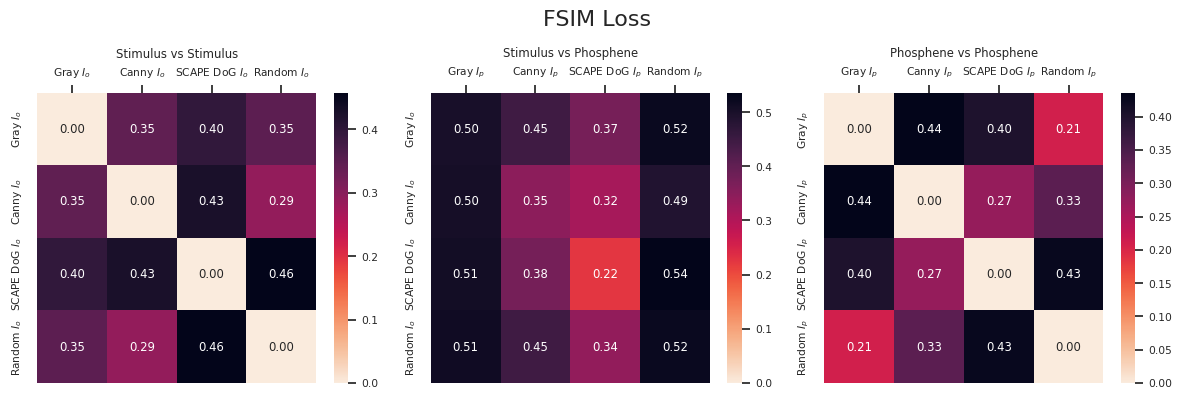

In [79]:
import piq
torch.use_deterministic_algorithms(False)

fsim_loss = piq.FSIMLoss(chromatic=False, min_length=7, scales=4).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, fsim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='FSIM Loss')

matrix_dict['fsim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix, 
    'phos_phos': phos_phos_matrix
}

### Learned Perceptual Image Patch Similarity (LPIPS)

In [80]:
# LPIPS_loss = piq.LPIPS()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, LPIPS_loss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='LPIPS Loss')

# matrix_dict['lpips'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }

### Perceptual Image-Error Assessment through Pairwise Preference (PieAPP)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/pieapp.py:171: UserWarning: The original PieAPP supports only RGB images.The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original PieAPP supports only RGB images.'


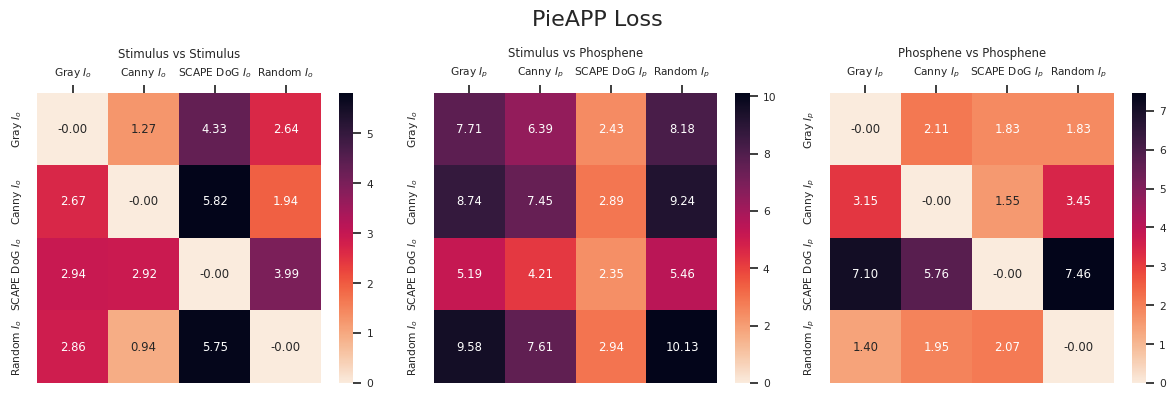

In [81]:
pieapp_loss = piq.PieAPP()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, pieapp_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='PieAPP Loss')

matrix_dict['pieapp'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### Deep Image Structure and Texture Similarity (DISTS)

In [82]:
# dists_loss = piq.DISTS()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dists_loss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DISTS Loss')

# matrix_dict['dists'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }


### Content Loss

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


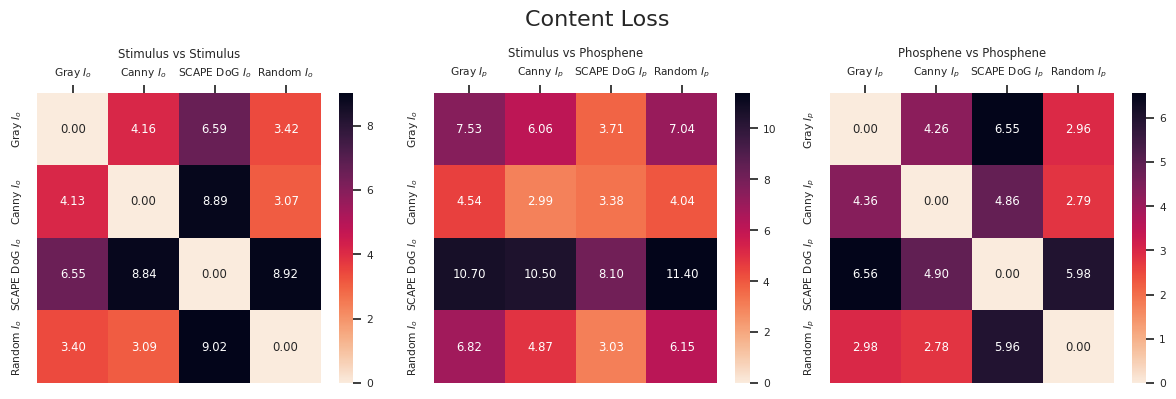

In [83]:
contentloss = piq.ContentLoss(feature_extractor='vgg19', normalize_features=False, layers = ['relu2_2'], distance="swd")

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, contentloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Content Loss')

matrix_dict['content'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### Strucural Similarity (SSIM)

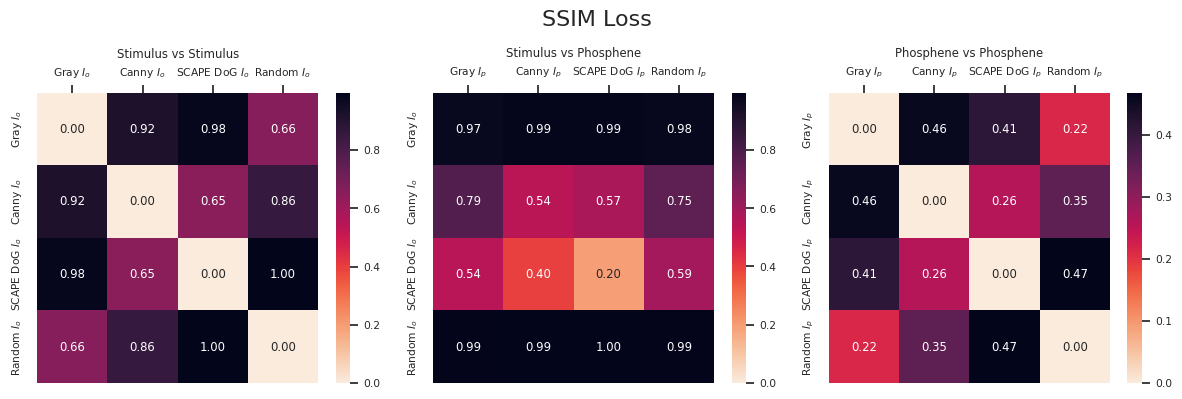

In [84]:
ssim_loss = piq.SSIMLoss()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, ssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SSIM Loss')

matrix_dict['ssim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Multi-Scale Structural Similarity (MS-SSIM)

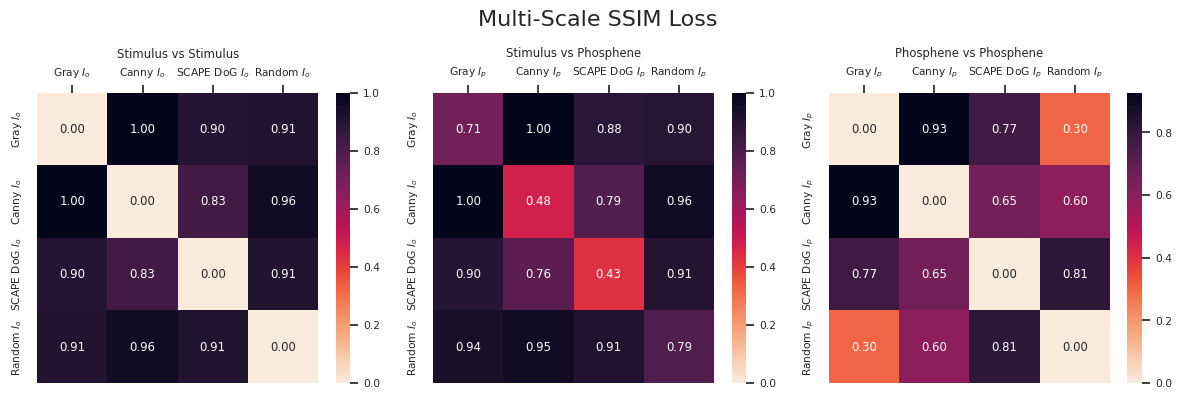

In [85]:
msssim_loss = piq.MultiScaleSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, msssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale SSIM Loss')

matrix_dict['msssim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Information Content Weighted Structural Similarity (IW-SSIM)

In [86]:
# iwssim_loss = piq.InformationWeightedSSIMLoss().cuda()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, iwssim_loss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Information-Weighted SSIM Loss')

# matrix_dict['iwssim'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }

### Visual Information Fidelity (VIFp)

In [87]:
# vifloss = piq.VIFLoss().cuda()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vifloss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VIF Loss')

# matrix_dict['vif'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }

### Spectral Residual based Similarity Measure (SR-SIM)

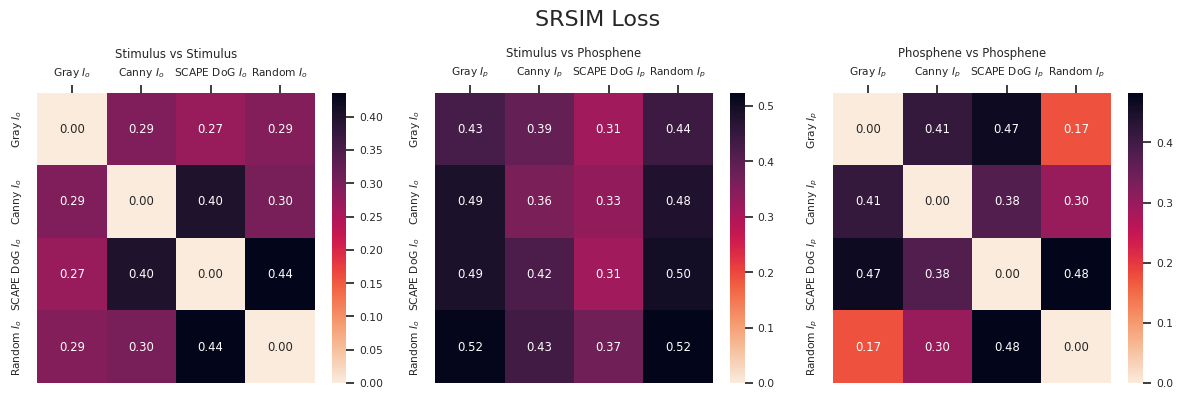

In [88]:
srsimloss = piq.SRSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, srsimloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SRSIM Loss')

matrix_dict['srsim'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

### Gradient Magnitude Similarity Deviation (GMSD)

In [89]:
# loss = piq.GMSDLoss().cuda()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='GMSD Loss')

# matrix_dict['gmsd'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }

In [90]:
# loss = piq.MultiScaleGMSDLoss().cuda()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale GMSD Loss')

# matrix_dict['ms_gmsd'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }

### Visual Saliency-induced Index (VSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/vsi.py:63: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '


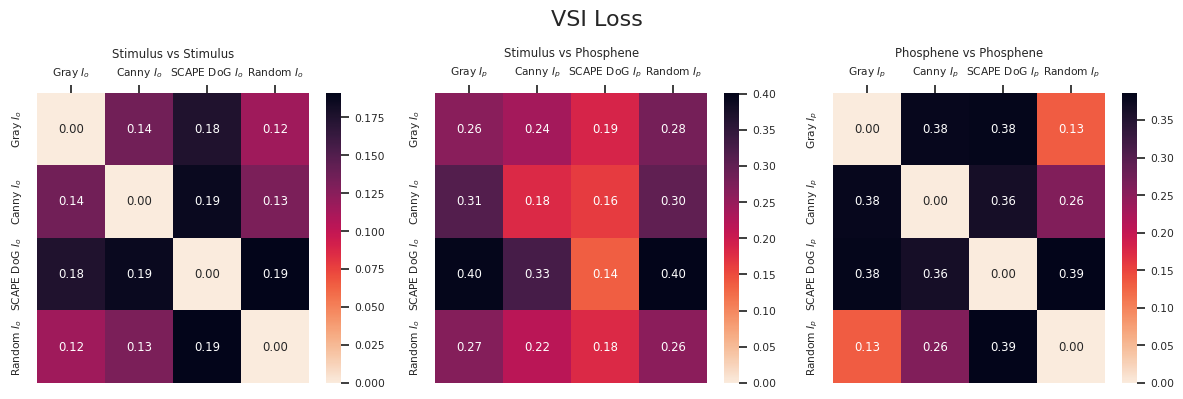

In [91]:
vsiloss = piq.VSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VSI Loss')

matrix_dict['vsi'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}


### DCT Subband Similarity Index (DSS)

In [92]:
# dssloss = piq.DSSLoss().cuda()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dssloss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DSSIM Loss')

# matrix_dict['dssim'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }

### Haar Perceptual Similarity Index (HaarPSI)

In [93]:
# haarloss = piq.HaarPSILoss(scales=3).cuda()

# stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, haarloss)
# plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='HaarPSI Loss')

# matrix_dict['haarpsi'] = {
#     'stim_stim': stim_stim_matrix,
#     'stim_phos': stim_phos_matrix,
#     'phos_phos': phos_phos_matrix
# }


### Mean Deviation Similarity Index (MDSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/mdsi.py:66: UserWarning: The original MDSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original MDSI supports only RGB images. The input images were converted to RGB by copying '


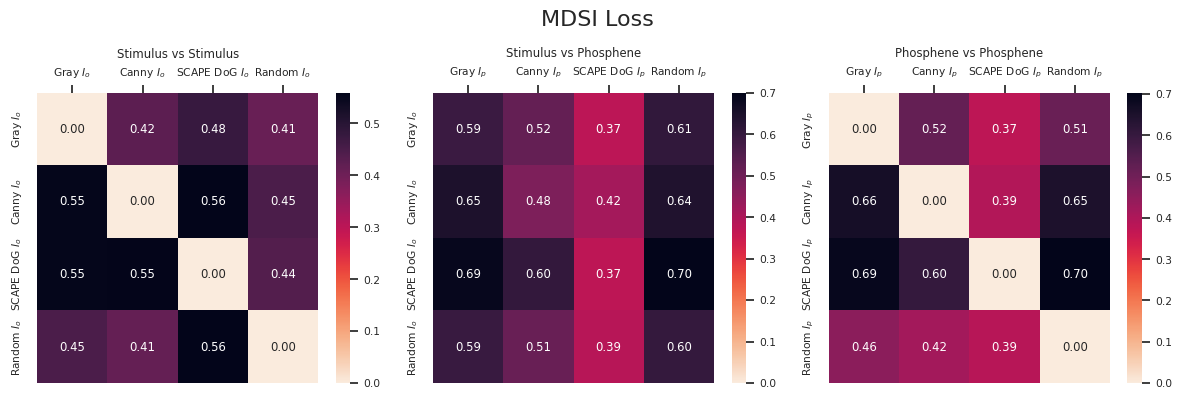

In [94]:
mdsiloss = piq.MDSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, mdsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='MDSI Loss')

matrix_dict['mdsi'] = {
    'stim_stim': stim_stim_matrix,
    'stim_phos': stim_phos_matrix,
    'phos_phos': phos_phos_matrix
}

# Save results as CSV

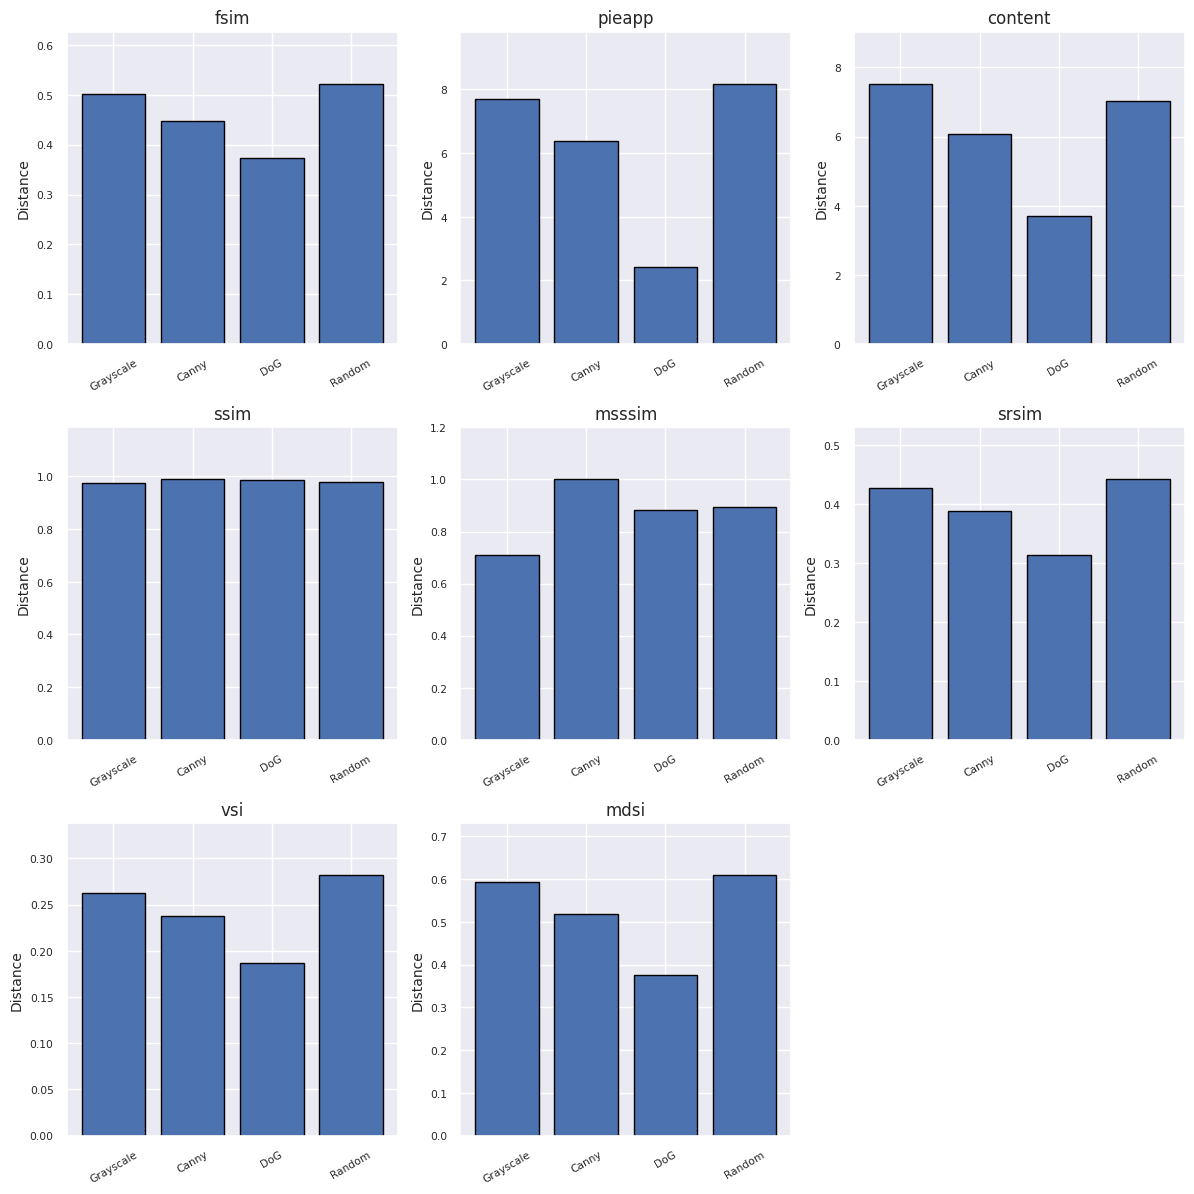

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

methods = ['Grayscale', 'Canny', 'DoG', 'Random']
metrics = list(matrix_dict.keys())

# Plot a bar chart per metric
n = len(metrics)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    # Extract the 0th row of stim_phos: original image vs each phosphene map
    stim_phos = matrix_dict[metric]['stim_phos']
    # If it's a torch tensor, move to CPU and convert to numpy:
    if hasattr(stim_phos, 'cpu'):
        stim_phos = stim_phos.cpu().numpy()
    values = stim_phos[0, :]

    ax.bar(methods, values, edgecolor='black')
    ax.set_title(metric, fontsize=12)
    ax.set_ylabel('Distance', fontsize=10)
    ax.set_ylim(0, values.max() * 1.2)
    ax.tick_params(axis='x', rotation=30)

# Remove any unused axes
for ax in axes[len(metrics):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Expected structure:
# matrix_dict[metric] = {
#   'stim_stim': 2D array [n_methods x n_methods],
#   'stim_phos': 2D array [n_methods x n_methods],
#   'phos_phos': 2D array [n_methods x n_methods]
# }
# Order of methods (must match how matrices were built)
METHODS = ['Grayscale', 'Canny', 'DoG', 'Random']

def build_lowlevel_table(matrix_dict, row_index=0):
    """
    Create a DataFrame: rows = metrics, cols = METHODS.
    Values = stim_vs_phos distances, taking row 'row_index'
    which should correspond to the original stimulus type you want
    as reference (often 0, the 'Grayscale I_s' row).
    """
    rows = []
    idx = []
    for metric, mats in matrix_dict.items():
        stim_phos = mats['stim_phos']
        if hasattr(stim_phos, 'cpu'):
            stim_phos = stim_phos.cpu().numpy()
        vals = stim_phos[row_index, :]
        rows.append(np.array(vals, dtype=float))
        idx.append(metric)
    df = pd.DataFrame(rows, index=idx, columns=METHODS)
    return df

def to_latex_table(df, caption, label, floatfmt="{:.3f}"):
    df_fmt = df.copy()
    for c in df_fmt.columns:
        df_fmt[c] = df_fmt[c].map(lambda x: floatfmt.format(x))
    latex = df_fmt.to_latex(
        escape=True,
        caption=caption,
        label=label,
        index=True,
        multicolumn=False,
        multicolumn_format='c',
        column_format='l' + 'c'*len(df.columns)
    )
    return latex

# Example usage:
# df_low = build_lowlevel_table(matrix_dict)  # uses first row of stim_phos
# print(to_latex_table(df_low, "Low level fidelity on COCO (distance, lower is better).", "tab:low_coco"))


# RDM

Pixel-RSA (ρ, p):
  grayscale    → ρ = 0.485, p = 1.62e-07
  DoG_response → ρ = 0.146, p = 0.136
  canny_edge   → ρ = -0.105, p = 0.285
  random       → ρ = 0.071, p = 0.469


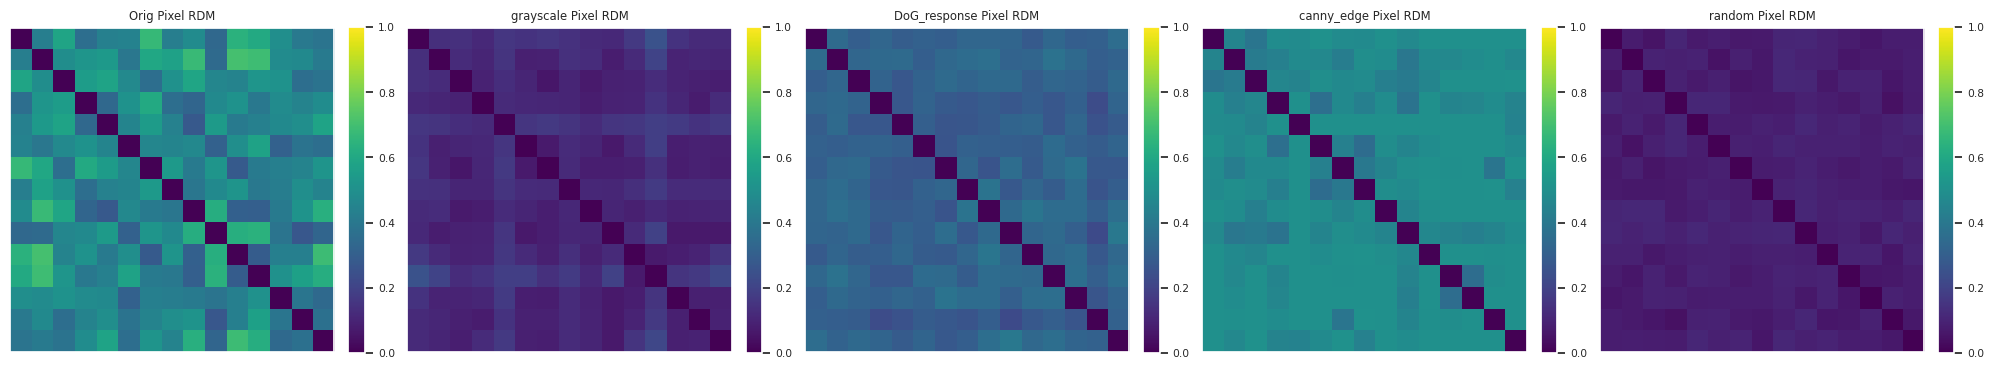

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats           import spearmanr

# 1) Gather raw-pixel representations
methods = [k for k in image_processing_dict[0].keys() if k!='image']
N       = len(image_processing_dict)

orig_vecs = []
phos_vecs = {m: [] for m in methods}

for idx in sorted(image_processing_dict.keys()):
    img = image_processing_dict[idx]['image'][0,0].cpu().numpy()
    orig_vecs.append(img.ravel())

    for m in methods:
        ph = image_processing_dict[idx][m]['phosphenes'][0,0].cpu().numpy()
        phos_vecs[m].append(ph.ravel())

orig_vecs = np.stack(orig_vecs, axis=0)      # shape (N, D)
for m in methods:
    phos_vecs[m] = np.stack(phos_vecs[m], axis=0)

# create one RNG once for reproducibility
_jitter_rng = np.random.default_rng(1234)

def corr01_rdm(X: np.ndarray, jitter: float = 1e-8) -> np.ndarray:
    """
    Build a correlation‐distance RDM in [0,1], with a tiny jitter
    so that no row is perfectly constant.
    
    :param X:       data matrix (N patterns × D dims)
    :param jitter:  standard deviation of additive Gaussian noise
    :returns:       (N×N) symmetric RDM with entries in [0,1]
    """
    # 1) break perfect constants
    Xj = X + jitter * _jitter_rng.standard_normal(X.shape)
    
    # 2) compute 1−corr, which pdist returns in [0,2], so divide by 2 → [0,1]
    D = squareform(pdist(Xj, metric='correlation')) / 2.0
    
    # 3) numerical safety: clip to [0,1]
    return np.clip(D, 0.0, 1.0)

def euclid01_rdm(X):
    D = squareform(pdist(X, metric='euclidean'))
    return D / D.max()

def cosine_rdm(X):
    # cosine returns in [0,2] when using pdist, so also divide by 2
    D = squareform(pdist(X, metric='cosine')) / 2.0
    return np.clip(D, 0.0, 1.0)

rdm_orig = corr01_rdm(orig_vecs)
rdm_phos = {m: corr01_rdm(phos_vecs[m]) for m in methods}

# 3) RSA: correlate upper triangle of each RDM to the original
tri = np.triu_indices(N, k=1)
v_o  = rdm_orig[tri]

print("Pixel-RSA (ρ, p):")
for m in methods:
    v_m = rdm_phos[m][tri]
    rho, p = spearmanr(v_o, v_m)
    print(f"  {m:12s} → ρ = {rho:.3f}, p = {p:.3g}")

# 4) Plot all RDMs
fig, axes = plt.subplots(1, len(methods)+1, figsize=(4*(len(methods)+1),4))
vmin, vmax = 0, 1

# original
im = axes[0].imshow(rdm_orig, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title("Orig Pixel RDM")
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

# each phosphene method
for i, m in enumerate(methods, start=1):
    im = axes[i].imshow(rdm_phos[m], cmap='viridis', vmin=vmin, vmax=vmax)
    axes[i].set_title(f"{m} Pixel RDM")
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

for ax in axes:
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


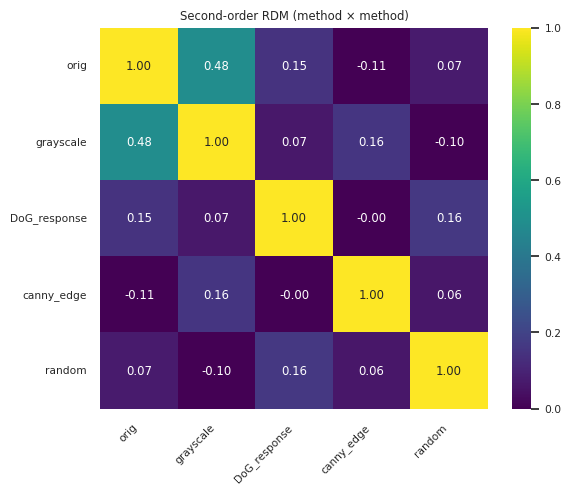

In [97]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats     import spearmanr

# 1) collect all first-order RDMs in one dict
all_rdms = {'orig': rdm_orig}
all_rdms.update({m: rdm_phos[m] for m in methods})

# 2) vectorize each RDM’s upper triangle
vecs = {}
N = rdm_orig.shape[0]
tri = np.triu_indices(N, k=1)
for name, rdm in all_rdms.items():
    vecs[name] = rdm[tri]

# 3) compute the method×method Spearman correlation matrix
M = len(vecs)
names = list(vecs.keys())
second_order = np.zeros((M, M))
for i, ni in enumerate(names):
    for j, nj in enumerate(names):
        rho, _ = spearmanr(vecs[ni], vecs[nj])
        second_order[i, j] = rho  # or 1-rho if you want a dissimilarity

# 4) plot it
plt.figure(figsize=(6,5))
sns.heatmap(second_order, vmin=0, vmax=1, cmap='viridis',
            xticklabels=names, yticklabels=names,
            annot=np.round(second_order,2), fmt='.2f')
plt.title("Second‐order RDM (method × method)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
